# 0.0. CROSS-SELL PROJECT

## 0.0. IMPORTS

In [5]:
# data manipulation
import pandas as pd
import numpy  as np

# data visutalization
import matplotlib.pyplot as plt
import seaborn           as sns

# stats
import scipy as ss

#encoding
from imblearn.combine      import SMOTETomek
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder

# feature selection
from boruta                    import BorutaPy
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# modeling
from sklearn.ensemble    import RandomForestClassifier
from sklearn.ensemble    import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn             import base
from sklearn             import linear_model as lm
from sklearn             import neighbors    as nh
import                          xgboost      as xgb

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#metrics
import scikitplot as skplt
from   sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score

# tuning
import optuna

#display
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib.pyplot import figure

## 0.1. HELPER FUNCTIONS

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'fivethirtyeight' )
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    #sns.set()
    sns.set_style('ticks')
    

def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m



class KFoldTargetEncoder(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        
        return self
    
    
    def transform(self,X):
    
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2021)
        print(kf)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            
            #train set and validation set
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            
            #test set you take the average of the target values of all samples that have a given category in the entire train set.
            X[col_mean_name].fillna(mean_of_target, inplace = True)
            
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            
        return X



def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']



def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


    
def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    balanced_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 20000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        balanced_accuracy = accuracy_score(y_val_fold, yhat_1)
        balanced_list.append(balanced_accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(balanced_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

#Suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format

## 0.2. LOADING DATA

In [7]:
df = pd.read_csv('../data/raw/train.csv')

In [8]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.00,0,> 2 Years,Yes,40454.00,26.00,217,1
1,2,Male,76,1,3.00,0,1-2 Year,No,33536.00,26.00,183,0
2,3,Male,47,1,28.00,0,> 2 Years,Yes,38294.00,26.00,27,1
3,4,Male,21,1,11.00,1,< 1 Year,No,28619.00,152.00,203,0
4,5,Female,29,1,41.00,1,< 1 Year,No,27496.00,152.00,39,0


# 1.0 DATA DESCRIPTION

## 1.1 CHECKING NAN, TYPES AND COLS

In [9]:
df1 = df.copy()

In [10]:
# Lowering the letter cases
df1.columns = map(str.lower, df1.columns)

In [11]:
# Checking number of rows and columns
print ('Number of rows: {}'.format(df1.shape[0]))
print ('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


In [12]:
#Checking NAs
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [13]:
#Checking data types
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.2. NUMERICAL ATTRIBUTES

In [14]:
#Creating dataframes with categorical and numerical attributes
num_attributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64'])

In [15]:
#Checking numerical attributes. Mainly stats. Distribuition, possible outliers and quick insights
#https://pkghosh.wordpress.com/2017/10/09/combating-high-cardinality-features-in-supervised-machine-learning/
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,381109.00,381108.00,190555.00,190555.00,110016.69,0.00,-1.20
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,driving_license,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35
3,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
4,previously_insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97
5,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.13,1.77,34.00
6,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
7,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20
8,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30


## 1.3. CATEGORICAL ATTRIBUTES

In [16]:
cat_attributes.apply(lambda x: x.unique())

gender                             [Male, Female]
vehicle_age       [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                          [Yes, No]
dtype: object

<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

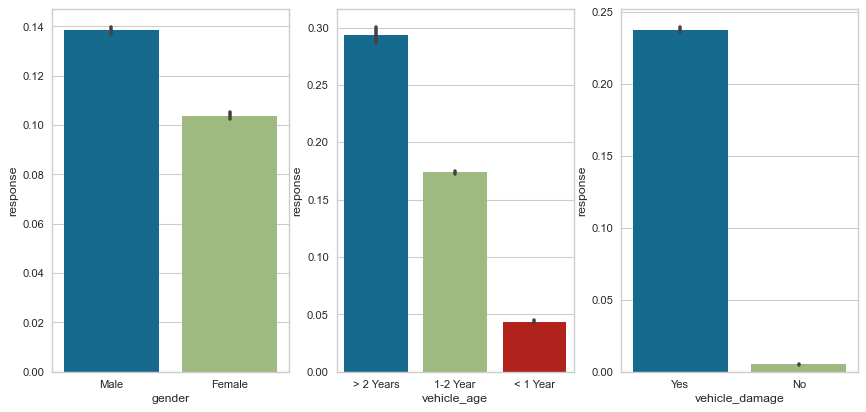

In [17]:
figure(figsize=(13, 6), dpi=80)

plt.subplot (1,3,1)
sns.barplot(x='gender', y='response', data =df1)

plt.subplot (1,3,2)
sns.barplot(x='vehicle_age', y='response', data =df1)


plt.subplot (1,3,3)
sns.barplot(x='vehicle_damage', y='response', data =df1)

## 1.4. TARGET VARIABLE

In [18]:
#Checking the % of responders who wants and doesnt. 88% do not want insurance, 12% do.
df1['response'].value_counts().apply(lambda x: x/len(df1))

0   0.88
1   0.12
Name: response, dtype: float64

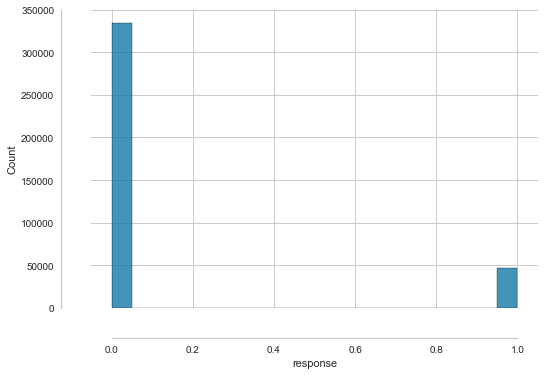

In [19]:
sns.histplot(df1, x='response')
sns.despine(offset = 30, trim = True)

# 2.0. EXPLORATORY DATA ANALYSIS

## 2.0.1 HYPOTHESYS

- People is equaly interested in insurance regardless their gender **FALSE**
- The older the vehicle the greater is the interest in acquiring an insurance **TRUE****
- If the owner damaged his vehicle before, he is more likely to acquire an insurance **TRUE**
- People who has driving license are more interested in insurance **TRUE**
- Different regions have different interesst in insurance **TRUE**
- Different policy sales channel have different outcome for the customer **TRUE**
- Who was previosly insured is less likely to acquire a new insurance service (had already showed commitment) **TRUE**
- The higher Annual Premium, the lower interest in insurance **FALSE**
- The higher vintage, the higher interest in insurance **FALSE**
- The higher age, the higher interest in insurance **TRUE**

In [20]:
df2 = df1.copy()

## 2.1. People who has driving license are more interested in insurance

<AxesSubplot:xlabel='response', ylabel='driving_license'>

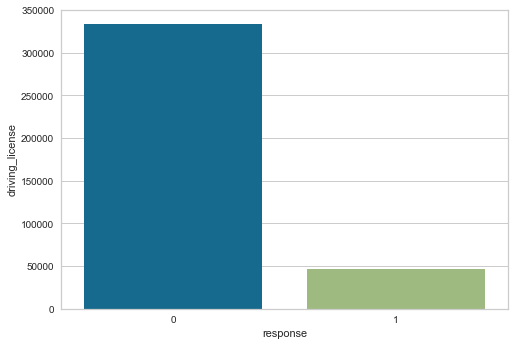

In [21]:
aux = df2[['driving_license', 'response']].groupby('response').sum().reset_index()
aux
sns.barplot(x='response', y='driving_license', data=aux)

In [22]:
pd.crosstab(df2['driving_license'], df2['response'])

response,0,1
driving_license,,
0,771,41
1,333628,46669


## 2.2 Different regions have different interest in insurance

,region_code,response
0,28.00,19917
1,8.00,3257
2,41.00,2224
3,46.00,2032
4,29.00,1365


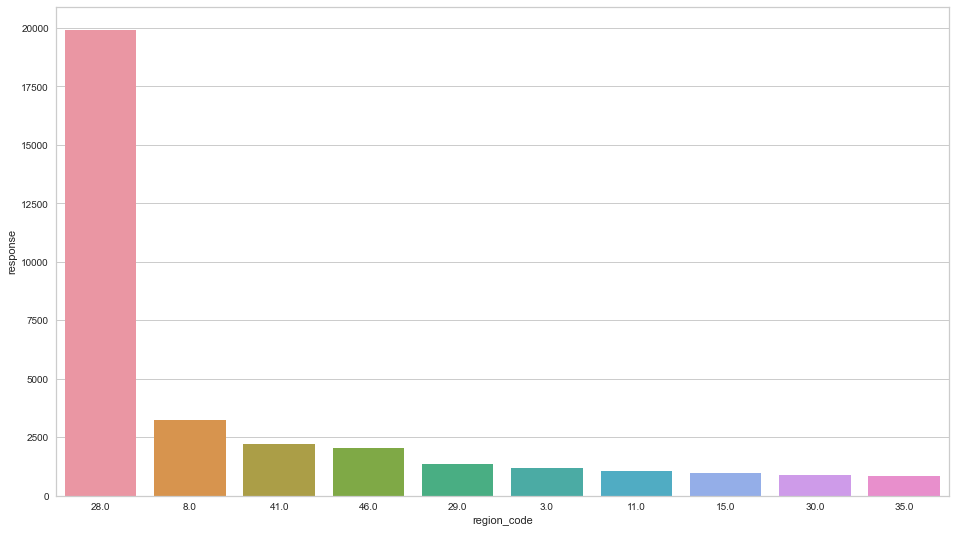

In [23]:
figure(figsize=(16,9))
aux = df2[['region_code', 'response']].groupby('region_code').sum().sort_values(by = 'response', ascending = False).reset_index()
sns.barplot(x='region_code', y='response', data=aux, order = aux['region_code'].head(10))
aux.head()

## 2.3 Different policy sales channel have different outcome for the customer

,policy_sales_channel,response
0,26.00,15891
1,124.00,13996
2,152.00,3858
3,156.00,2297
4,157.00,1794


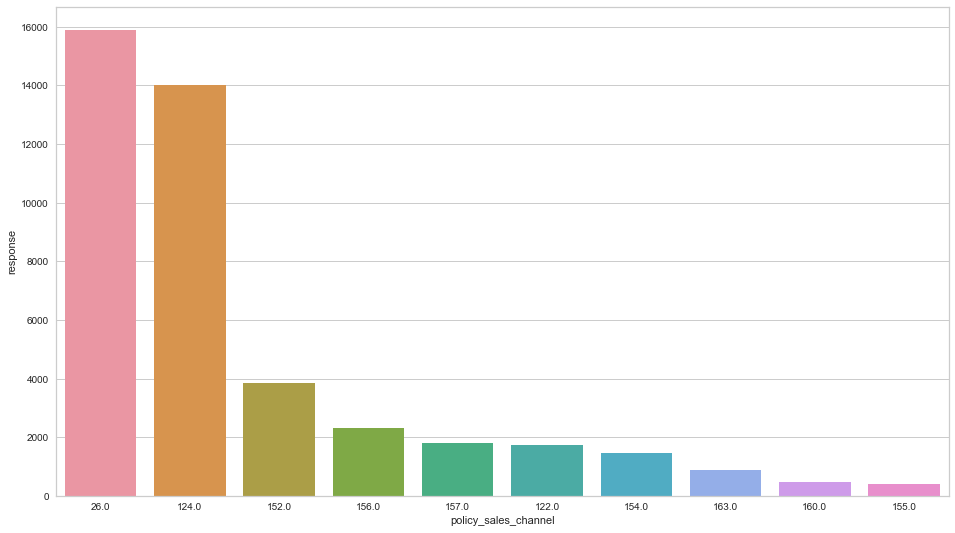

In [24]:
figure(figsize=(16,9))
aux = df2[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().sort_values(by = 'response', ascending = False).reset_index()
sns.barplot(x='policy_sales_channel', y='response', data=aux, order = aux['policy_sales_channel'].head(10))
aux.head()

## 2.4 Who was previosly insured is less likely to acquire a new insurance service

,response,previously_insured
0,0,174470
1,1,158


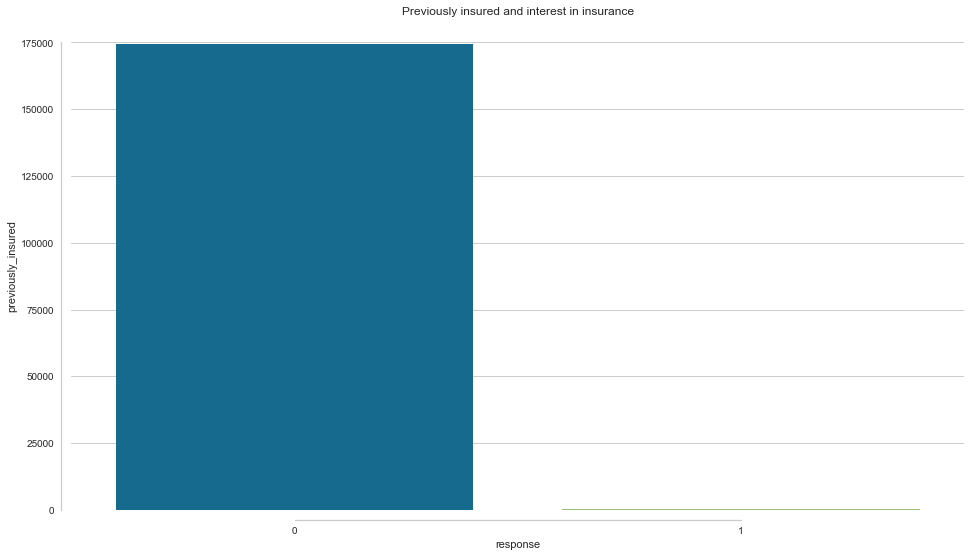

In [25]:
figure(figsize=(16,9))
aux = df2[['previously_insured', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='previously_insured', data=aux )
sns.despine(offset = 10, trim = True)
plt.title('Previously insured and interest in insurance');
aux

## 2.5 The higher Annual Premium, the lower interest in insurance

In [26]:
aux1 = df2[df2['response'] == 1]
aux2 = df2[df2['response'] == 0]

x = aux1['annual_premium'].mean()
y = aux2['annual_premium'].mean()

print('Mean Annual premium of who is interested     :', x)
print('Mean Annual premium of who is not interested :', y)

Mean Annual premium of who is interested     : 31604.092742453435
Mean Annual premium of who is not interested : 30419.16027559891


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

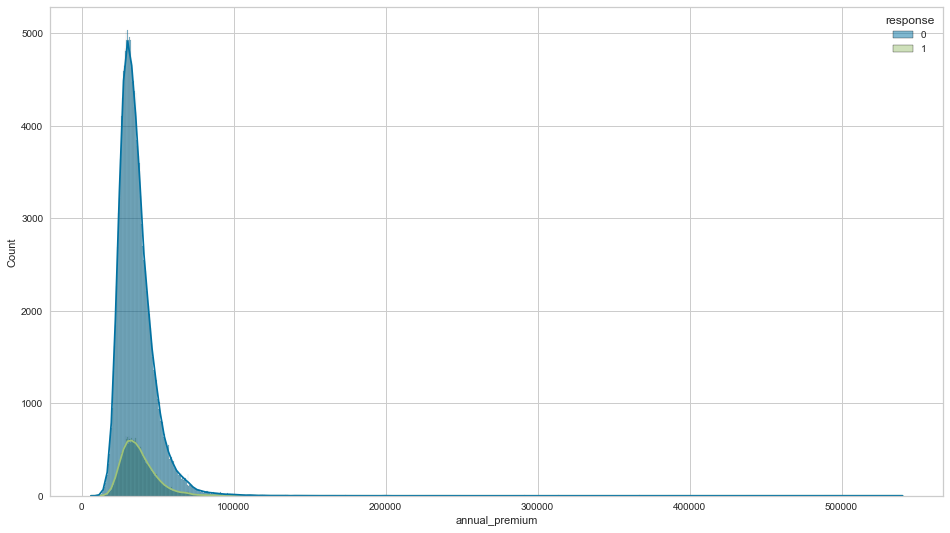

In [27]:
figure(figsize=(16,9))
aux3 = df2[df2['annual_premium'] > 3000]

sns.histplot(aux3, x="annual_premium", hue="response", kde = True)

## 2.6 The higher vintage, the higher interest in insurance

In [28]:
aux1 = df2[df2['response'] == 1]
aux2 = df2[df2['response'] == 0]

x = aux1['vintage'].mean()
y = aux2['vintage'].mean()

print('Mean Vintage of who is interested     :', x)
print('Mean Vintage of who is not interested :', y)

Mean Vintage of who is interested     : 154.11224577178334
Mean Vintage of who is not interested : 154.38024336197176


<AxesSubplot:xlabel='response', ylabel='vintage'>

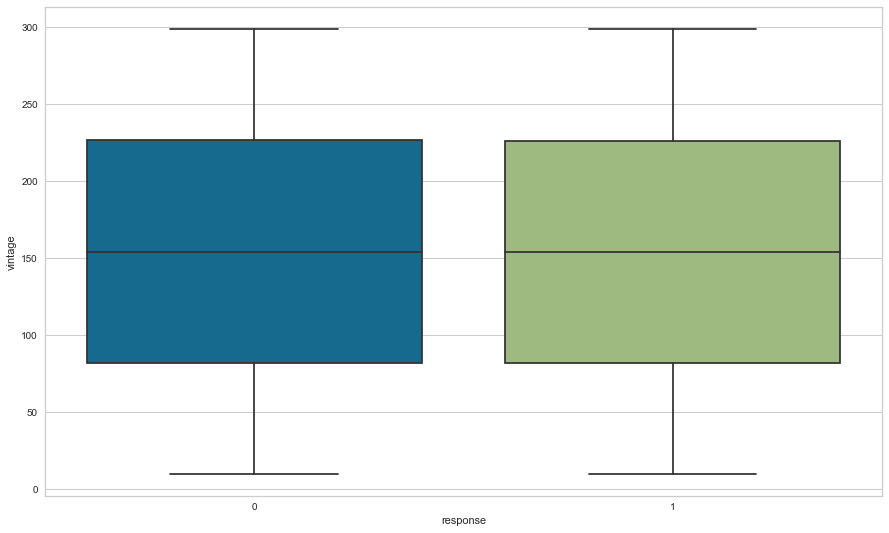

In [29]:
figure(figsize=(15,9))
sns.boxplot(x='response', y='vintage', data=df2)

## 2.7 The higher age, the higher interest in insurance

In [30]:
aux1 = df2[df2['response'] == 1]
aux2 = df2[df2['response'] == 0]

x = aux1['age'].mean()
y = aux2['age'].mean()

print('Mean age of interested:', x)
print('Mean age of not interested:', y)

Mean age of interested: 43.435559837293944
Mean age of not interested: 38.17822720761725


<AxesSubplot:xlabel='response', ylabel='age'>

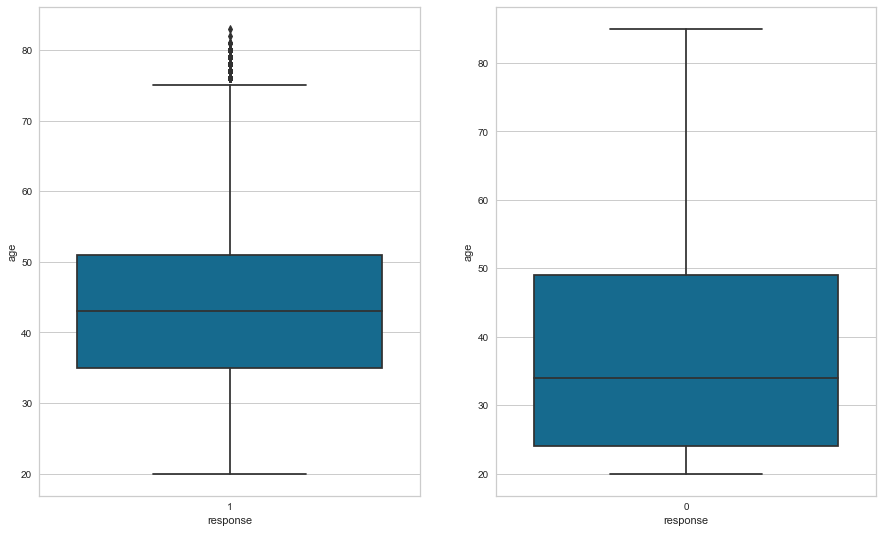

In [31]:
figure(figsize=(15,9))
plt.subplot(1,2,1)
sns.boxplot(x='response', y='age', data=aux1)
plt.subplot(1,2,2)
sns.boxplot(x='response', y='age', data=aux2)

# 3.0 BIVARIATE ANALYSIS

<AxesSubplot:>

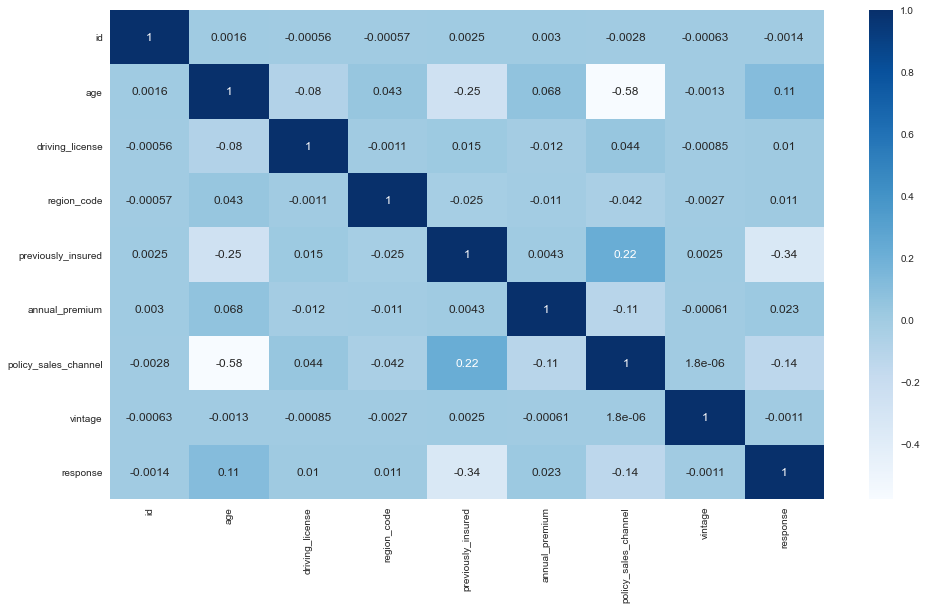

In [32]:
figure(figsize=(16,9))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, cmap='Blues')

# 5.0. DATA PREPARATION

In [33]:
df3=df2.copy()
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.00,0,> 2 Years,Yes,40454.00,26.00,217,1
1,2,Male,76,1,3.00,0,1-2 Year,No,33536.00,26.00,183,0
2,3,Male,47,1,28.00,0,> 2 Years,Yes,38294.00,26.00,27,1
3,4,Male,21,1,11.00,1,< 1 Year,No,28619.00,152.00,203,0
4,5,Female,29,1,41.00,1,< 1 Year,No,27496.00,152.00,39,0


## 5.1 Encoding

In [34]:
#Gender Encoding

df3['gender'] = df3['gender'].map({'Male': 1, 'Female': 0})

#Vehicle Damage Encoding

df3['vehicle_damage'] = df3['vehicle_damage'].map({'Yes': 1, 'No': 0})
df3.head()

#Vehicle Age Encoding
df3 = pd.get_dummies(df3, prefix='vehicle_age', columns=['vehicle_age'])

## 5.2 K-Fold Encoding

In [35]:
#Target encoding the region code with K-Folds

target_encoder = KFoldTargetEncoder('region_code','response', n_fold=5)
df3 = target_encoder.fit_transform(df3)

#Previous correlation was 0.011 vs 0.13 now, higher, but still lowish.

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, region_code_Kfold_Target_Enc and, response is 0.13725713378653778.


In [36]:
#Target encoding the region code with K-Folds

target_encoder = KFoldTargetEncoder('policy_sales_channel','response', n_fold=5)
df3 = target_encoder.fit_transform(df3)

#Previous correlation was -0.014 vs 0.26 now, below 30, so we will take it.
#Generalizing, anything over 50 is high, between 49-30 is moderate, and below 30 is low.

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, policy_sales_channel_Kfold_Target_Enc and, response is 0.26192635929712205.


## 5.3. Splitting the dataset into Training and Test

In [37]:
#Lets drop the old columns which we just encoded.

df3.drop(columns=['policy_sales_channel', 'region_code', 'id'], inplace = True)

In [38]:
#Leaving response as the last feature will help when splitting the dataset

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_1-2 Year',
                 'vehicle_age_< 1 Year',
                 'vehicle_age_> 2 Years',
                 'region_code_Kfold_Target_Enc',
                 'policy_sales_channel_Kfold_Target_Enc', 
                 'response']

df3 = df3.reindex(columns = columns_order)

In [39]:
#Splitting data into train and test 80/20

msk = np.random.rand(len(df)) < 0.80
train = df3[msk]
test = df3[~msk]

In [40]:
#This is going to select the first rows to the training sets, and leave the last one, which is the response,
#to the test set

x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1:]

x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1:]

## 5.4. Rescalling 

<AxesSubplot:ylabel='vintage'>

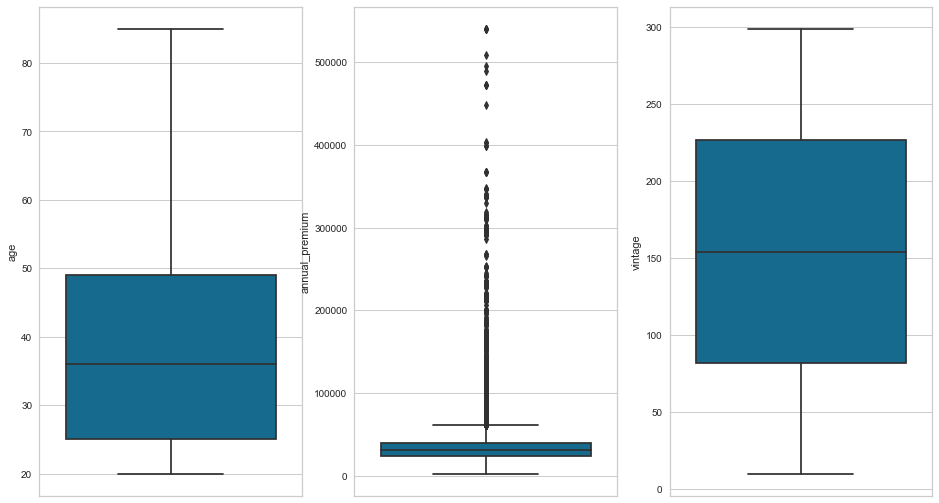

In [41]:
figure(figsize=(16,9))
plt.subplot(1,3,1)
sns.boxplot(y='age', data=df2) #StandardScalar ou MinMax

plt.subplot(1,3,2)
sns.boxplot(y='annual_premium', data=df2) #RobustScalar

plt.subplot(1,3,3)
sns.boxplot(y='vintage', data=df2) #StandardScalar ou MinMax

In [42]:
rs = RobustScaler()
mms = MinMaxScaler()

#age
x_train['age'] = mms.fit_transform(x_train.loc[:, 'age':].values)
x_test['age'] = mms.transform(x_test.loc[:, 'age':].values)

#vintage
x_train['vintage'] = mms.fit_transform(x_train.loc[:, 'vintage':].values)
x_test['vintage'] = mms.transform(x_test.loc[:, 'vintage':].values)

#anual premium
x_train['annual_premium'] = rs.fit_transform(x_train.loc[:, 'annual_premium':].values)
x_test['annual_premium'] = rs.transform(x_test.loc[:, 'annual_premium':].values)

## 5.4. Resampling the target variable with SmoteTomek

In [43]:
# We are going to deal with the unbalance of the data set by using
# the SMOTE algorithm with TomekLinks, which oversample the data while it
# creates synthetic samples, and then undersamples it based on both
#observations nearest neighbors that belong to different classes.

print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0           267552
1            37513
dtype: int64

In [44]:
x_train_res, y_train_res = SMOTETomek(random_state=42).fit_resample(x_train, y_train)

In [45]:
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0           262711
1           262711
dtype: int64

# 6.0. FEATURE SELECTION

## 6.1.0. Features Analysis

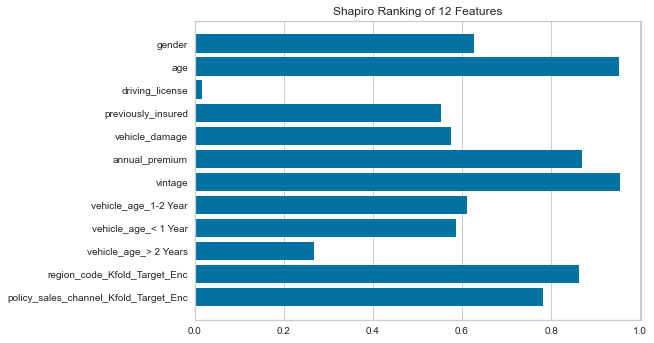

In [51]:
visualizer = Rank1D(algorithm='shapiro')
visualizer.fit(x_train_res, y_train_res)
visualizer.transform(x_train_res)
visualizer.show();

## 6.1.1. Recursive Feature Elimination with Cross Validation

In [47]:
#preparating for selection
x_train_res_s = x_train_res.values
y_train_res_s = y_train_res.values.ravel()

In [48]:
# Create the RFE object and compute a cross-validated score.
# et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 )

# min_features_to_select = 1  # Minimum number of features to consider

# rfeet = RFECV(estimator = et, step = 1, cv = StratifiedKFold(2),
#               scoring = 'precision',
#               min_features_to_select= min_features_to_select)

# rfeet.fit(x_train_res_s, y_train_res_s)

# print("Optimal number of features : %d" % rfeet.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(min_features_to_select,
#                len(rfeet.grid_scores_) + min_features_to_select),
#          rfeet.grid_scores_)
# plt.show()

## 6.1.2 Boruta Feature Selector 

In [55]:
#define Classifier
rf = RandomForestClassifier( n_jobs = -1 )

boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( x_train_res_s, y_train_res_s )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	6


In [56]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train.columns, cols_selected_boruta ) )

In [57]:
cols_selected_boruta

['age',
 'previously_insured',
 'vehicle_damage',
 'vintage',
 'region_code_Kfold_Target_Enc',
 'policy_sales_channel_Kfold_Target_Enc']

In [58]:
cols_not_selected_boruta

['annual_premium',
 'driving_license',
 'gender',
 'vehicle_age_1-2 Year',
 'vehicle_age_< 1 Year',
 'vehicle_age_> 2 Years']

# 7.0 MACHINE LEARNING MODELING

In [59]:
# First, lets select the features after the analysis, RFE and Boruta.
# Then, lets use it to select on both the x training and x test sets

In [60]:
cols_selected = [   'age',
                    'previously_insured',
                    'vehicle_damage',
                    'vintage',
                    'annual_premium',
                    'region_code_Kfold_Target_Enc',
                    'policy_sales_channel_Kfold_Target_Enc'
                ]

x_train_res = x_train_res[cols_selected].copy()
x_test = x_test[cols_selected].copy()

In [61]:
# Since we have a very unbalanced distribuition of classes, with a lot of
# 0's and not a lot of 1's, the precision score wouldnt be ideal, because
# it measures the correct predictions in relationship ot the total predic-
# tions made. Recall measures the the correct predctions over the correct
# plus incorrect ones (TP/TP+FN). Meaning: FN = the model is saying the
# person wants insurance, but doesnt.

## 7.1 Logistic Regression

In [62]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 ) 

# model training
lr_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_lr = lr_model.predict( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_lr)))
print('Precision: '   + str(precision_score(y_test,yhat_lr)))

Balanced Accuracy: 0.7898241004521824
Precision: 0.26843546407326974


## 7.2. K-Nearest Neighbors

In [63]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train_res,y_train_res.values.ravel())
    yhat = knn_model.predict(x_test)
    mean_rcc[n-1] = balanced_accuracy_score(y_test, yhat)

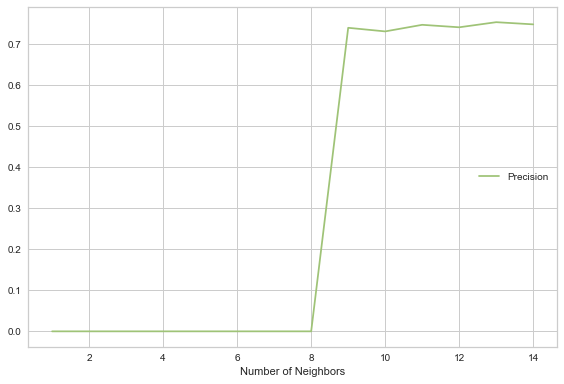

In [64]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [65]:
# model definition with k = 10
knn_model = nh.KNeighborsClassifier( n_neighbors = 10 )

# model training
knn_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_knn = knn_model.predict( x_test ) 

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_knn)))

Balanced Accuracy: 0.7304768002791657


## 7.3. Extra Trees

In [66]:
# model definition
et = ExtraTreesClassifier( n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_et = et.predict(x_test)

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_et)))

Balanced Accuracy: 0.633330858728889


## 7.4. XGBoost Classifier

In [67]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 2, 
                              subsample = 0.7,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9)

#model training
model_xgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_xgb)))

Balanced Accuracy: 0.7927364405780136


## 7.5. Gaussian NB Classifier

In [68]:
#model definition
model_nb = GaussianNB()

#train model
model_nb.fit( x_train_res, y_train_res.values.ravel() )

#prediction
yhat_nb = model_nb.predict( x_test )
yhat_nb_1 = model_nb.predict_proba( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_nb)))

Balanced Accuracy: 0.7844873886008956


## 7.6. Random Forest Classifier

In [73]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 42)

#train model
model_rf.fit( x_train_res, y_train_res.values.ravel() )

#predict
yhat_rf = model_rf.predict( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_rf)))

Balanced Accuracy: 0.792459500508773


# 8.0. CROSS-VALIDATION WITH TOP-K METRICS

In [75]:
df4 = df3.copy()

In [76]:
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, 5, df4, Verbose = False)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, 5, df4, Verbose = False)
et_val = cross_validation(et, x_train_res, y_train_res, 5, df4, Verbose = False)
nb_val = cross_validation(model_nb, x_train_res, y_train_res, 5, df4, Verbose = False)
rf_val = cross_validation(model_rf, x_train_res, y_train_res, 5, df4, Verbose = False)

In [77]:
results = pd.concat([xgb_val,lr_val,et_val,nb_val,rf_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,GaussianNB,0.79,0.71,0.00,0.98,0.00,0.78,0.00,0.30,0.00
0,ExtraTreesClassifier,0.92,0.89,0.00,0.95,0.00,1.00,0.00,0.38,0.00
0,XGBClassifier,0.78,0.72,0.02,0.94,0.05,0.77,0.04,0.29,0.02
0,LogisticRegression,0.80,0.73,0.00,0.93,0.00,0.79,0.00,0.30,0.00
0,RandomForestClassifier,0.80,0.74,0.00,0.92,0.00,0.81,0.00,0.31,0.00


# 9.0 HYPERPARAMETER FINE-TUNING

## 9.1. Extra Trees Cassifier

In [87]:
def objective(trial):

        random_state = 42
        n_jobs = -1
        max_depth = trial.suggest_int("max_depth", 80, 120)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    

        classifier_obj = ExtraTreesClassifier(random_state       = random_state,
                                              n_jobs             = n_jobs,
                                              max_depth          =  max_depth,
                                              n_estimators       = n_estimators,
                                              min_samples_split  = min_samples_split,
                                              min_samples_leaf   = min_samples_leaf
                                              
                                             )

  
        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df4, Verbose = False)
    
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Precision: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-06-07 11:50:59,115] A new study created in memory with name: no-name-072e7c0a-e84d-4ba7-ad95-04243dafd6ea
[I 2021-06-07 11:51:34,069] Trial 0 finished with value: 0.9616 and parameters: {'max_depth': 106, 'n_estimators': 98, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9616.
[I 2021-06-07 11:52:04,163] Trial 1 finished with value: 0.9637 and parameters: {'max_depth': 92, 'n_estimators': 83, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9637.
[I 2021-06-07 11:52:33,544] Trial 2 finished with value: 0.957 and parameters: {'max_depth': 84, 'n_estimators': 95, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9637.
[I 2021-06-07 11:53:10,802] Trial 3 finished with value: 0.957 and parameters: {'max_depth': 107, 'n_estimators': 120, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9637.
[I 2021-06-07 11:54:12,486] Trial 4 finished with value: 0.9639 and parameter

[I 2021-06-07 12:28:41,427] Trial 38 finished with value: 0.9615 and parameters: {'max_depth': 86, 'n_estimators': 95, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 36 with value: 0.9642.
[I 2021-06-07 12:29:51,079] Trial 39 finished with value: 0.9537 and parameters: {'max_depth': 81, 'n_estimators': 83, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 36 with value: 0.9642.
[I 2021-06-07 12:30:37,133] Trial 40 finished with value: 0.9638 and parameters: {'max_depth': 89, 'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9642.
[I 2021-06-07 12:31:35,182] Trial 41 finished with value: 0.9638 and parameters: {'max_depth': 85, 'n_estimators': 92, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9642.
[I 2021-06-07 12:32:20,219] Trial 42 finished with value: 0.9642 and parameters: {'max_depth': 90, 'n_estimators': 96, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 36 

[I 2021-06-07 13:05:40,145] Trial 76 finished with value: 0.9638 and parameters: {'max_depth': 85, 'n_estimators': 92, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 54 with value: 0.9643.
[I 2021-06-07 13:06:45,813] Trial 77 finished with value: 0.9641 and parameters: {'max_depth': 81, 'n_estimators': 104, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 54 with value: 0.9643.
[I 2021-06-07 13:07:51,102] Trial 78 finished with value: 0.9642 and parameters: {'max_depth': 80, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 54 with value: 0.9643.
[I 2021-06-07 13:09:14,776] Trial 79 finished with value: 0.9523 and parameters: {'max_depth': 80, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 54 with value: 0.9643.
[I 2021-06-07 13:10:14,053] Trial 80 finished with value: 0.9642 and parameters: {'max_depth': 91, 'n_estimators': 95, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 

Precision: 0.9643
Best hyperparameters: {'max_depth': 81, 'n_estimators': 101, 'min_samples_split': 2, 'min_samples_leaf': 2}


## 9.2. Gaussian NB Classifier

In [88]:
def objective(trial):

        
       
        var_smoothing = trial.suggest_float('var_smoothing',1e-9, 1, log = True )
        

        classifier_obj = GaussianNB( var_smoothing = var_smoothing )
        

        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df4, Verbose = False)
        
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Precision: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-06-07 15:05:14,230] A new study created in memory with name: no-name-9e1e7e8e-3ceb-4e67-ba5d-6dc63cc4b0b2
[I 2021-06-07 15:05:15,408] Trial 0 finished with value: 0.9782 and parameters: {'var_smoothing': 0.000624625341579604}. Best is trial 0 with value: 0.9782.
[I 2021-06-07 15:05:16,586] Trial 1 finished with value: 0.9781 and parameters: {'var_smoothing': 1.6128516433651143e-08}. Best is trial 0 with value: 0.9782.
[I 2021-06-07 15:05:17,770] Trial 2 finished with value: 0.9782 and parameters: {'var_smoothing': 1.559738594263286e-05}. Best is trial 0 with value: 0.9782.
[I 2021-06-07 15:05:19,085] Trial 3 finished with value: 0.9781 and parameters: {'var_smoothing': 2.3243470981901794e-08}. Best is trial 0 with value: 0.9782.
[I 2021-06-07 15:05:20,358] Trial 4 finished with value: 0.9781 and parameters: {'var_smoothing': 1.5180159723835438e-08}. Best is trial 0 with value: 0.9782.
[I 2021-06-07 15:05:21,611] Trial 5 finished with value: 0.9782 and parameters: {'var_smoothin

[I 2021-06-07 15:06:17,408] Trial 48 finished with value: 0.9782 and parameters: {'var_smoothing': 0.03368312232183448}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:06:18,755] Trial 49 finished with value: 0.9782 and parameters: {'var_smoothing': 0.11505915054282302}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:06:20,166] Trial 50 finished with value: 0.9781 and parameters: {'var_smoothing': 1.2359923716427987e-09}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:06:21,533] Trial 51 finished with value: 0.9787 and parameters: {'var_smoothing': 0.908585088143744}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:06:22,985] Trial 52 finished with value: 0.9785 and parameters: {'var_smoothing': 0.3800283958776737}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:06:24,323] Trial 53 finished with value: 0.9787 and parameters: {'var_smoothing': 0.914148577975413}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:06:25,680] Trial 54 finished with val

[I 2021-06-07 15:07:20,789] Trial 96 finished with value: 0.9787 and parameters: {'var_smoothing': 0.9793127005025285}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:07:22,091] Trial 97 finished with value: 0.9782 and parameters: {'var_smoothing': 0.11711792499395808}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:07:23,401] Trial 98 finished with value: 0.9785 and parameters: {'var_smoothing': 0.354527463830138}. Best is trial 18 with value: 0.9787.
[I 2021-06-07 15:07:24,716] Trial 99 finished with value: 0.9785 and parameters: {'var_smoothing': 0.43912803702252845}. Best is trial 18 with value: 0.9787.


Precision: 0.9787
Best hyperparameters: {'var_smoothing': 0.9912176235982135}


## 10.0 FINAL MODEL

In [89]:
#definition
model_nb = GaussianNB() 
#training
model_nb.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_nb = model_nb.predict_proba(x_test)

# 11.0 THE BUSINESS PERFORMANCE EVALUATION

## SCENARIO 1

**By making 20.000 calls, which translates to about 26% of our base list, we would be able to reach about 65% of the clients who would like to purchase our insurance services.**

In [90]:
data = x_test.copy()

data['response'] = y_test.copy()
data['score'] = yhat_nb[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [92]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(percent_of_dataset)
print(recall_at_20000)

0.26300562832044605
0.6490159834728716


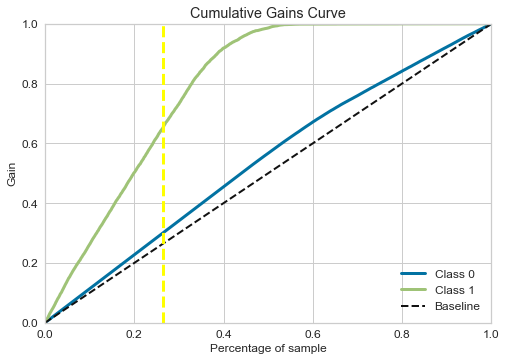

In [93]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
plt.axvline(0.2634, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

## SCENARIO 2

**By making 25.100 calls, which translates to about 33% of our base list, we would be able to reach about 80% of the clients who would like to purchase our insurance services.**

In [95]:
percent_of_dataset = 25100 / len(data)
recall_at_25100 = recall_at_k(data, k = 25100)

print(percent_of_dataset)
print(recall_at_25100)

0.3300720635421598
0.8034141567902577


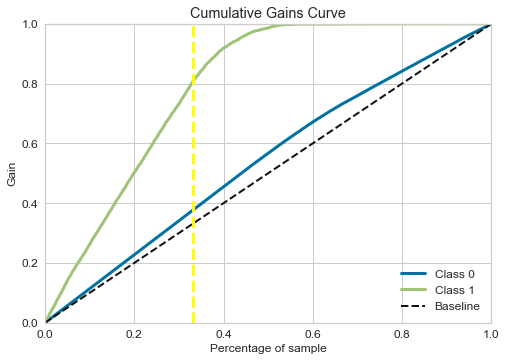

In [96]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
plt.axvline(0.3306, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

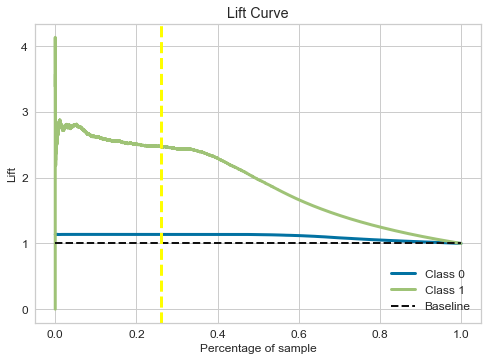

In [97]:
skplt.metrics.plot_lift_curve(y_test, yhat_nb)
plt.axvline(0.26, 0, 1, color='yellow', ls='--', lw=3);

**By making around 15.000 calls, or about 20% of our base, we would be able to reach about 2.5x more clientes than if we used a random choice model**

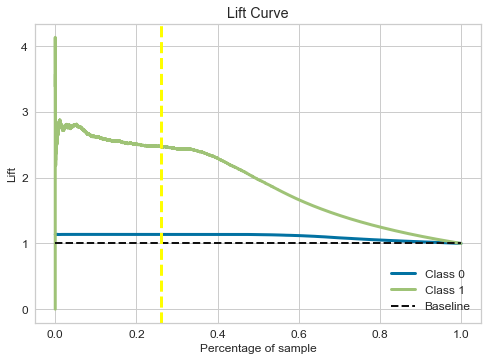

In [99]:
skplt.metrics.plot_lift_curve(y_test, yhat_nb)
plt.axvline(0.26, 0, 1, color='yellow', ls='--', lw=3);

In [103]:
data

response
0           66847
1            9197
dtype: int64

**Baseline model would predict 26% of all people interested in insurance by making 20 thousand calls, whereas, our model, would predict 65.5%. If each insurance is 1000 this represents a diference of 29,60 million dollars in 20 thousand calls**

In [106]:
random_choice = (26/100) * len(data)
model         = (65/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

19771440 revenue with random choice
49428600 revenue with model
difference in $: 29657159


**With 26 thousand calls and 4 hundred, our model would predict 80% of all people interested, and the difference from baseline would rise to 35,7 million dollars**

In [101]:
random_choice = (33/100) * len(data)
model         = (80/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

25094520 revenue with random choice
60835200 revenue with model
difference in $: 35740680
